In [2]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json



import random
import time
from pathlib import Path
from os import path
import os, sys
from typing import Optional

from util.logger import setup_logger

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import torch.distributed as dist

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_DABDETR, build_dab_deformable_detr, build_dab_deformable_detr_deformable_encoder_only
from models import build_dab_dino_deformable_detr
from util.utils import clean_state_dict

import matplotlib.pyplot as plt
import torchvision

/home/mak/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
class Args(argparse.Namespace):
    use_dn=True
    scalar=5
    label_noise_scale=0.2
    box_noise_scale=0.4
    contrastive=False
    use_mqs=False
    use_lft=False
    lr=0.0001
    lr_backbone=1e-05
    batch_size=1
    weight_decay=0.0001
    epochs=50
    lr_drop=40
    override_resumed_lr_drop=False
    drop_lr_now=False
    save_checkpoint_interval=10
    clip_max_norm=0.1
    modelname='dn_dab_detr'
    frozen_weights=None
    backbone='resnet50'
    dilation=False
    position_embedding='sine'
    pe_temperatureH=20
    pe_temperatureW=20
    batch_norm_type='FrozenBatchNorm2d'
    return_interm_layers=False
    backbone_freeze_keywords=None
    enc_layers=6
    dec_layers=6
    dim_feedforward=2048
    hidden_dim=256
    dropout=0.0
    nheads=8
    num_queries=300
    num_results=300
    pre_norm=False
    num_select=300
    transformer_activation='prelu'
    num_patterns=0
    random_refpoints_xy=False
    two_stage=False
    num_feature_levels=4
    dec_n_points=4
    enc_n_points=4
    masks=False
    aux_loss=True
    set_cost_class=2
    set_cost_bbox=5
    set_cost_giou=2
    cls_loss_coef=1
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    focal_alpha=0.25
    dataset_file='coco'
    coco_path='/home/mak/repos/datasets/coco_original'
    coco_panoptic_path=None
    remove_difficult=False
    fix_size=False
    output_dir='logs/dn_DABDETR/R50'
    note=''
    device='cuda'
    seed=42
    resume=''
    pretrain_model_path=None
    finetune_ignore=None
    start_epoch=0
    eval=False
    num_workers=10
    debug=False
    find_unused_params=False
    save_results=False
    save_log=False
    world_size=1
    dist_url='env://'
    rank=0
    local_rank=None
    amp=False

args = Args()

In [6]:
# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
dataset_train = build_dataset(image_set='train', args=args)

loading annotations into memory...
Done (t=11.32s)
creating index...
index created!


In [8]:
print(len(dataset_train[0]))
print(dataset_train[0][0].shape)
print(dataset_train[1][0].shape)
dataset_train[0][1]

2
torch.Size([3, 512, 682])
torch.Size([3, 480, 646])


{'boxes': tensor([[0.5205, 0.6888, 0.9556, 0.5955],
         [0.2635, 0.2472, 0.4989, 0.4764],
         [0.3629, 0.7329, 0.4941, 0.5106],
         [0.6606, 0.4189, 0.6789, 0.7815],
         [0.3532, 0.1326, 0.1180, 0.0969],
         [0.2269, 0.1298, 0.0907, 0.0972],
         [0.3317, 0.2269, 0.1313, 0.1469],
         [0.3571, 0.0792, 0.1481, 0.1481]]),
 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]),
 'image_id': tensor([9]),
 'area': tensor([282171.7812, 104435.5469, 116523.6641,  57095.6250,   5263.0371,
           3898.9131,   8482.9902,   6992.8281]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([736, 981])}

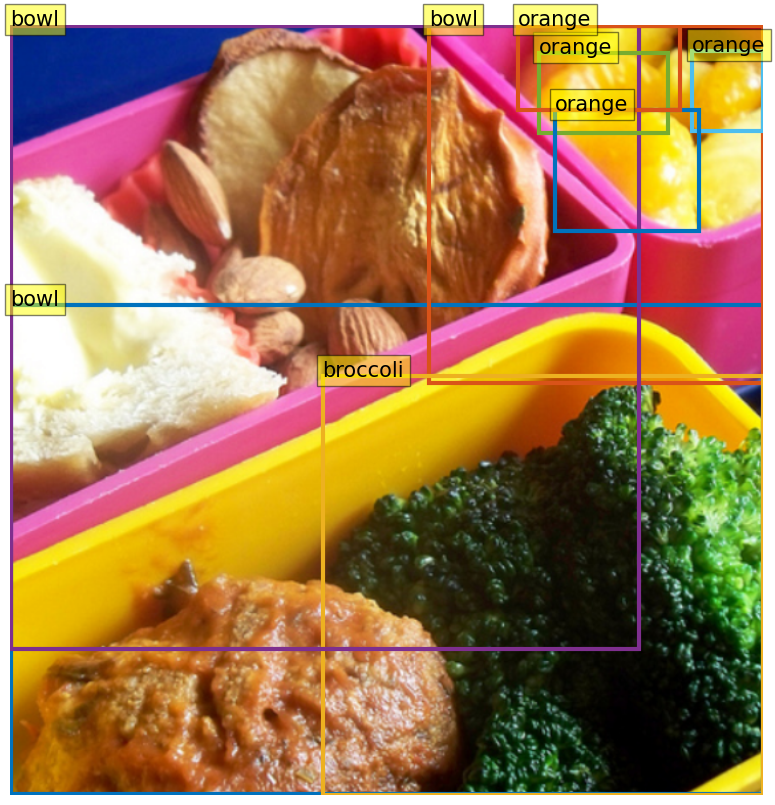

In [9]:
example = dataset_train[0]
plot_results(example[0], example[1]["labels"], example[1]["boxes"])

In [10]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers)

/home/mak/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
i = 0
for samples, targets in data_loader_train:
    i += 1
    if i > 2:
        break
samples.tensors.shape

torch.Size([1, 3, 896, 672])

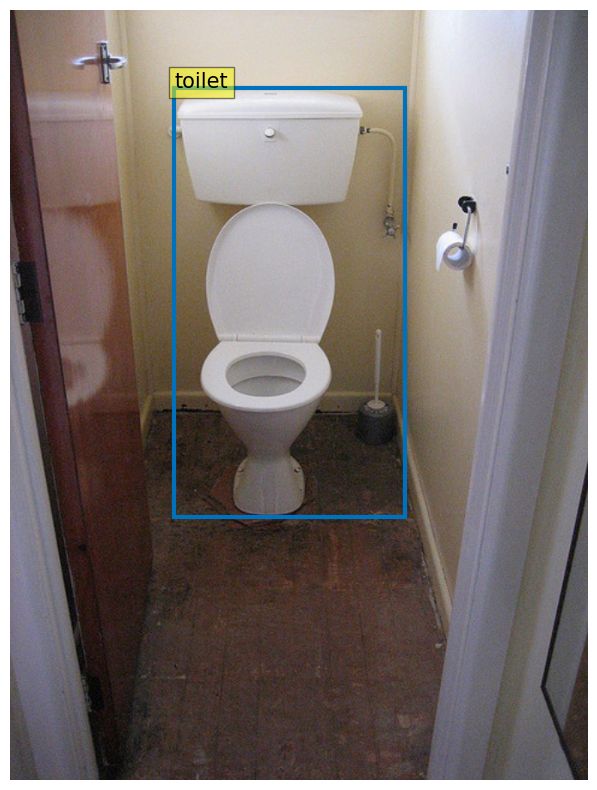

In [12]:
plot_results(samples.tensors[0], targets[0]["labels"], targets[0]["boxes"], mask=samples.mask[0])

In [13]:
from models import build_DABDETR
model, criterion, postprocessors = build_DABDETR(args)
device = "cuda"
model = model.to(device)

/home/mak/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mak/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
args.num_patterns

0

In [15]:
samples = samples.to(device)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
dn_args=(targets, args.scalar, args.label_noise_scale, args.box_noise_scale, args.num_patterns)
outputs, mask_dict = model(samples, dn_args=dn_args)
outputs

In [19]:
loss_dict = criterion(outputs, targets, mask_dict)
loss_dict

{'loss_ce': tensor(1.1076, device='cuda:0', grad_fn=<MulBackward0>),
 'class_error': tensor(100., device='cuda:0'),
 'loss_bbox': tensor(0.3287, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_giou': tensor(0.3865, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_xy': tensor(0.0574, device='cuda:0'),
 'loss_hw': tensor(0.2712, device='cuda:0'),
 'cardinality_error': tensor(298., device='cuda:0'),
 'loss_ce_0': tensor(1.2279, device='cuda:0', grad_fn=<MulBackward0>),
 'loss_bbox_0': tensor(0.3287, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_giou_0': tensor(0.3865, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_xy_0': tensor(0.0574, device='cuda:0'),
 'loss_hw_0': tensor(0.2712, device='cuda:0'),
 'cardinality_error_0': tensor(298., device='cuda:0'),
 'loss_ce_1': tensor(1.2182, device='cuda:0', grad_fn=<MulBackward0>),
 'loss_bbox_1': tensor(0.3287, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_giou_1': tensor(0.3865, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_xy_1': te